<a href="https://colab.research.google.com/github/wrightky/ANUGA_DXWorkshop/blob/main/WLAD_Model/WLAD_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<div align="center">**Wax Lake & Atchafalaya Delta Model**</div>
##<div align="center">ANUGA Tutorial</div>
##<div align="center">Kyle Wright</div>
###<div align="center">Delta-X Applications Workshop (May 5th, 2022)</div>

## Information on this session:

**Goal:** Introduce the basics of the hydrodynamic model for the Wax Lake & Atchafalaya Delta (WLAD) basin using ANUGA. This model solves the 2D shallow-water equations on an unstructured triangular grid. Note that the model structure has been slightly simplified for parts of this demonstration.

**Software:** ANUGA, Python, Jupyter Notebooks, other packages

**Installation:** None, this lab is run on the cloud in the Google `colaboratory` environment.

**Details:** In this tutorial, we will build, run, and analyze our model of the actively-aggrading WLAD basin. This is one of the two Delta-X study sites, and we will be simulating the period that aligns with the Spring 2021 campaign. Different cell blocks will demonstate how one can build the model mesh, initialize the domain, setup the parameters of the model, and run the simulation. 

The regular version of this model is written as a collection of Python scripts that are run in parallel on a high-performance computing cluster (e.g. [TACC](https://www.tacc.utexas.edu/)). However, we have simplified the model here to allow it to run in this notebook on Google Colab, so that we can demonstrate the workflow of the model, which is identical to that in the true version. The raw codes for the current parallel implementation have been included in this repository along with this notebook, so feel free to glance through those as well. 

This notebook is written in Python 3, and has been designed to run in the Google `colaboratory` environment, which provides a Jupyter notebook environment running on a virtual machine on the cloud. Nothing needs to be installed locally, as it is entirely run on Google Drive. All you need is a Google account. All of these scripts are stored on GitHub.

To start interacting with the notebook, make sure it is open in Colab (see `Open in Colab` link above). Once you're there, click `File` > `Save a Copy in Drive`.

# Setup Environment

The first thing we have to do is set up our environment. In Python, this means downloading all the necessary functions we want to use, including ANUGA.

Run the following cell to install the dependencies and some extra code for visualising on Colaboratory. The install should take less than a minute.

*Pro-tip: To run each code block, you can simply type `shift` + `enter`*

NOTE: Tutorial installation is based on the [2018 CSDMS Anuga Clinic](https://github.com/stoiver/anuga-clinic-2018), but updated to work in Python 3.

In [1]:
# Here we download/install all the files we need behind the scenes
try:
    import os
    os.chdir('/content')
    # Grab workbook files into colab directory
    !git clone https://github.com/wrightky/ANUGA_DXWorkshop.git
    # Install everything using some bash scripts
    !/bin/bash /content/ANUGA_DXWorkshop/anuga_tools/install_anuga_colab.sh
    !python /content/ANUGA_DXWorkshop/anuga_tools/install.py > /dev/null 2>&1 
except:
    pass

# Deal with some directory stuff
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
import sys
sys.path.append(os.path.join(workbookDir,"ANUGA_DXWorkshop"))
sys.path.append(os.path.join(workbookDir,"anuga_core"))

Cloning into 'ANUGA_DXWorkshop'...
remote: Enumerating objects: 278, done.
remote: Counting objects: 100% (278/278), done.
remote: Compressing objects: 100% (248/248), done.
remote: Total 278 (delta 41), reused 258 (delta 27), pack-reused 0
Receiving objects: 100% (278/278), 5.98 MiB | 16.25 MiB/s, done.
Resolving deltas: 100% (41/41), done.
(1) Install pip packages
(2) Install gdal
(3) Install netcdf4
(4) Download anuga_core github repository
(5) Install anuga
(6) Ready to go


# Import packages

Now that everything is installed, we can load the packages we want to use directly into this notebook.

In [23]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
import os
import anuga 
from anuga.utilities import animate
from anuga import Inlet_operator
from anuga.operators.baptist_operator import Baptist_operator

# Structure of the Code

The Delta-X WLAD model is currently broken up into five separate Python scripts to keep things clean and organized. These scripts can be found in the downloaded git repository (which you can navigate to on the left-hand side of this page and preview), and are organized as follows:

*   `settings.py` stores all of the typical settings that get changed between model runs, like whether the boundary conditions are steady/unsteady, timesteps and runtime for the model, friction coefficients, and filenames from which to grab model inputs. All other scripts import run settings from this file.
*   `tools.py` groups common operations into a collection of helper functions that are used behind the scenes. This script mostly serves to keep the main run scripts clean and legible.
*   `prepare_boundaries.py` is a serial script that downloads all the necessary gauge data from the USGS and NOAA servers for the simulation window to use for boundary conditions, and converts all that data into the required format. 
*   `prepare_topography.py` is another serial script that interpolates the starting bathymetry data (in ASCII format) onto our WLAD model domain mesh and saves the output onto disk in CSV format. This operation is expensive and only needs to be performed once, so we have separated it from the main run script to keep the parallel jobs streamlined.
*   `run_parallel.py` is the main parallel script that builds the WLAD model domain and runs the simulation according to the specified model settings. This script is designed to run in an MPI-compatible environment over multiple processors.

In addition, there are also two `.job` scripts, which are example bash submission scripts for running the serial and parallel codes using a SLURM scheduler (e.g. on an HPC cluster like TACC). The WLAD model is currently run on TACC distributed over 8 nodes with 48 tasks each (384 tasks total), with a wall clock time of about 10% of the simulation time. **Because this is too computationally expensive to replicate over colab, we will simplify and coarsen the WLAD model for the purpose of this demonstration.**

Additionally, we will only make use of the `settings` and `tools` scripts for the purposes of this demonstration. The rest of the steps in the other scripts will be recreated here in serial in order to demonstrate the workflow from which the WLAD model is constructed (in `run_parallel`).

In [8]:
# Import all default settings and helper functions
from ANUGA_DXWorkshop.WLAD_Model.settings import *
from ANUGA_DXWorkshop.WLAD_Model.tools import *
# Change directory
os.chdir('ANUGA_DXWorkshop/WLAD_Model')

# Create Domain and Mesh

The first thing we will do is construct our WLAD `domain` object. To instantiate our mesh, all we need to provide is the geometry of our model. Specifically, we need to load our model **boundary**, any **interior polygons** inside which we want different mesh resolutions, and specify the **mesh resolutions** for each region.

Using several remote sensing masks and an [automated mesh refinement method](https://github.com/passaH2O/meshrefinement), we already have a list of polygons inside which we expect very little hydrodynamic activity, with which we coarsen in the WLAD model to reduce computational demand. For details, see our [preprint](https://doi.org/10.31223/X57K9V).

In ANUGA, mesh resultion is enforced as a **maximum triangle size** (as an area in meters). Each of our polygons is already pre-labeled with the target resolution. *However, in order to reduce the file size of this model in this demonstration, we are going to make two changes to the default model:*

1. We reduce the base resolution of our model (the `base_res` variable we loaded from `settings`) from $625 m^2$ to $10000 m^2$
2. We convert most of our `interior_regions` to be `interior_holes`, meaning instead of modeling these areas with a coarse resolution, we treat them as empty regions inside our domain with no grid cells. 

These two simplifications substantially reduce the resulting number of grid cells, which helps keep our current model within the limits of colab's RAM. 

Default false northing is 10000000.000000.
ANUGA does not correct for differences in False Northings.
Figure files for each frame will be stored in _plot


(624040.222045, 680256.343655, 3220663.3324, 3302688.5856)

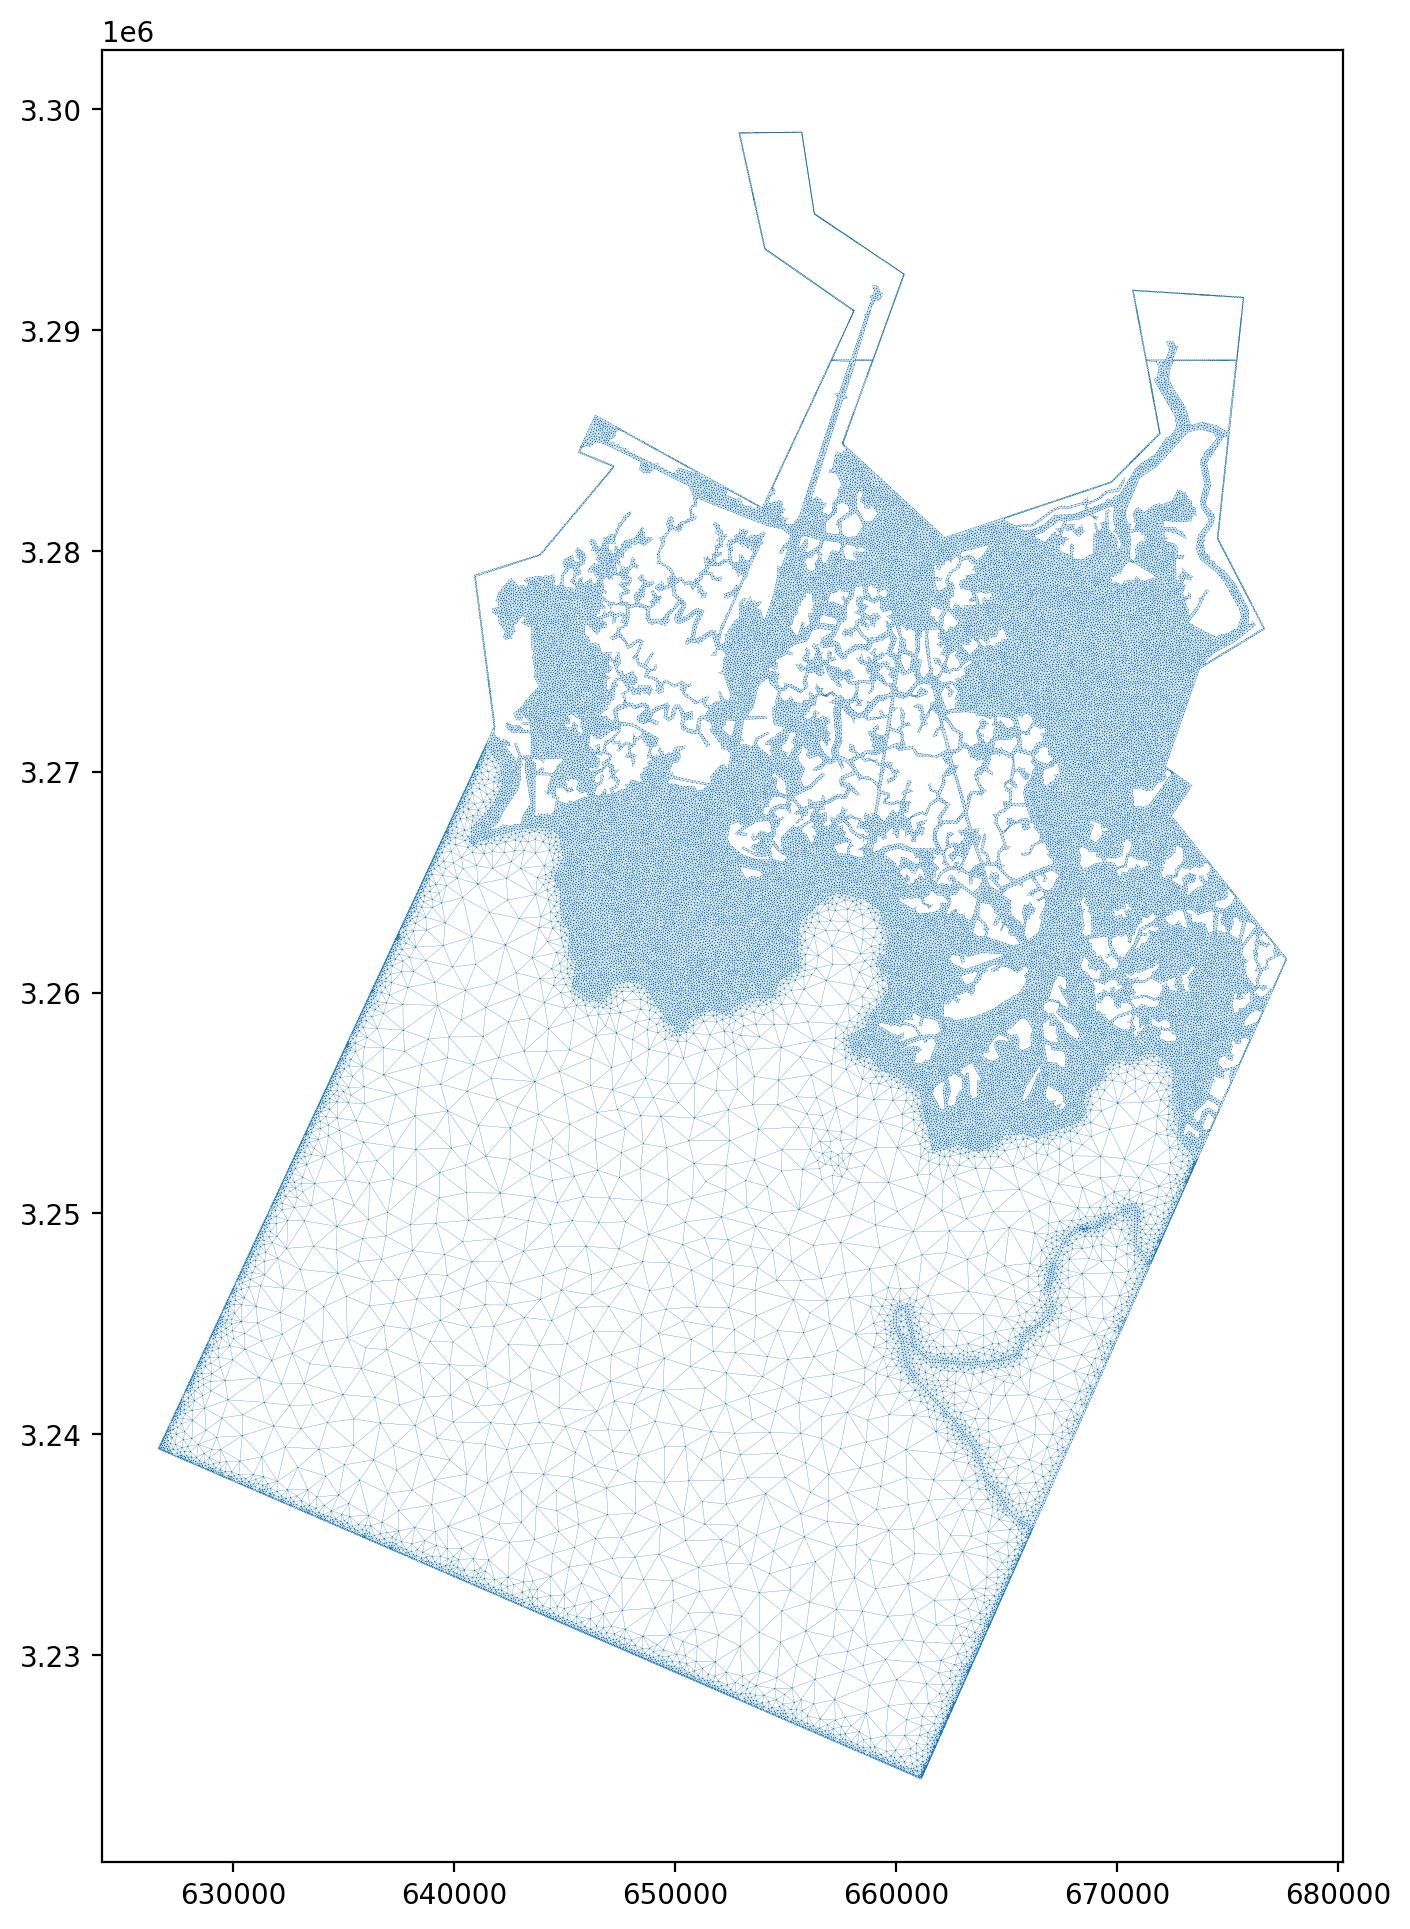

In [27]:
# Load the domain geometry using a function we imported from tools
bounding_polygon, boundary_tags, inside_regions, geo_reference = GenerateDomainGeometry()

# Modify the output to convert some regions to holes:
inside_holes = [i[0] for i in inside_regions if i[1]==62500]
inside_regions = [i for i in inside_regions if i[1]>62500]
base_res = 10000

# Instantiate our domain object
domain = anuga.create_domain_from_regions(bounding_polygon, boundary_tags,
                                          maximum_triangle_area=base_res,
                                          interior_regions=inside_regions,
                                          interior_holes=inside_holes,
                                          poly_geo_reference=geo_reference,
                                          mesh_geo_reference=geo_reference,
                                          mesh_filename = 'WLAD2.msh')

domain.set_name('WLAD')
domain.set_flow_algorithm('DE1') # Most accurate
domain.set_low_froude(1)  # Use low-froude DE1 to reduce flux damping
domain.set_minimum_allowed_height(0.005)  # Only store heights > 0.5 cm

# Plot the mesh
fig = plt.figure(figsize=(10, 12), dpi=200, facecolor='w', edgecolor='k')
dplotter = animate.Domain_plotter(domain)
plt.triplot(dplotter.triang, linewidth=0.1);
plt.axis('scaled')

In [28]:
# Let's inspect some statistics for our model mesh
print(domain.statistics())

------------------------------------------------
Mesh statistics:
  Number of triangles = 101552
  Extent [m]:
    x in [6.26596e+05, 6.77701e+05]
    y in [3.22439e+06, 3.29896e+06]
  Areas [m^2]:
    A in [1.41467e+02, 9.98721e+05]
    number of distinct areas: 101552
    Histogram:
      [1.41467e+02, 9.99994e+04[: 99424
      [9.99994e+04, 1.99857e+05[: 494
      [1.99857e+05, 2.99715e+05[: 214
      [2.99715e+05, 3.99573e+05[: 155
      [3.99573e+05, 4.99431e+05[: 279
      [4.99431e+05, 5.99289e+05[: 347
      [5.99289e+05, 6.99147e+05[: 243
      [6.99147e+05, 7.99005e+05[: 203
      [7.99005e+05, 8.98863e+05[: 113
      [8.98863e+05, 9.98721e+05]: 80
    Percentiles (10 percent):
      10155 triangles in [1.41467e+02, 4.21495e+03]
      10155 triangles in [4.21495e+03, 4.87770e+03]
      10155 triangles in [4.87770e+03, 5.32634e+03]
      10155 triangles in [5.32634e+03, 5.76852e+03]
      10155 triangles in [5.76852e+03, 6.23578e+03]
      10155 triangles in [6.23578e+03, 6.77

# Convert Bathymetry

Now that our `domain` object exists, we can begin populating it with data and information about our landscape. Let's begin with topographic information from our Delta-X bathymetry dataset. 

If we were beginning from scratch, we would first need to do a few transformations to our data to get it into a format ANUGA likes. The first few lines below convert data from the most-common GeoTIFF to an ESRI ASCII grid, to a NETCDF file, and finally interpolates that information to our model mesh. However, we have already run these operations to save time, and saved the resulting output as a CSV file. All we need to do is load it and add that data to our domain. Feel free to take a look at this cell, but for now, **we can skip it**.

In [ ]:
# Convert GeoTIFF to ASCII
# !gdal_translate -of AAIGrid  BathymetryPolygons/WLAD_topo.tif BathymetryPolygons/WLAD_topo.asc
# topography_source = r'BathymetryPolygons/WLAD_topo.asc'
# Convert from ASCII to DEM
# anuga.asc2dem(topography_source, use_cache=False, verbose=True)
# Convert from DEM to PTS
# anuga.dem2pts(topography_source.replace('.asc','.dem'),
#               use_cache=False, verbose=True)
# Interpolate onto our mesh:
# domain.set_quantity('elevation', 
#                     filename=topography_source.replace('.asc','.pts'),
#                     use_cache=False, verbose=True, alpha=0.1)
# Save to disk:
# topo = domain.quantities['elevation'].centroid_values
# np.savetxt(topography_source.replace('.asc','.csv'), topo, delimiter=",")

# Add Bathymetry

Because our bathymetry has already been converted, we can skip to adding it to our model domain.

In [ ]:
# Load pre-established elevation
topo = np.loadtxt(topography_source.replace('.asc','.csv'), delimiter=",")
domain.set_quantity('elevation', topo, location='centroids') 

(624040.222045, 680256.3436550001, 3220663.3324, 3302688.5856000003)

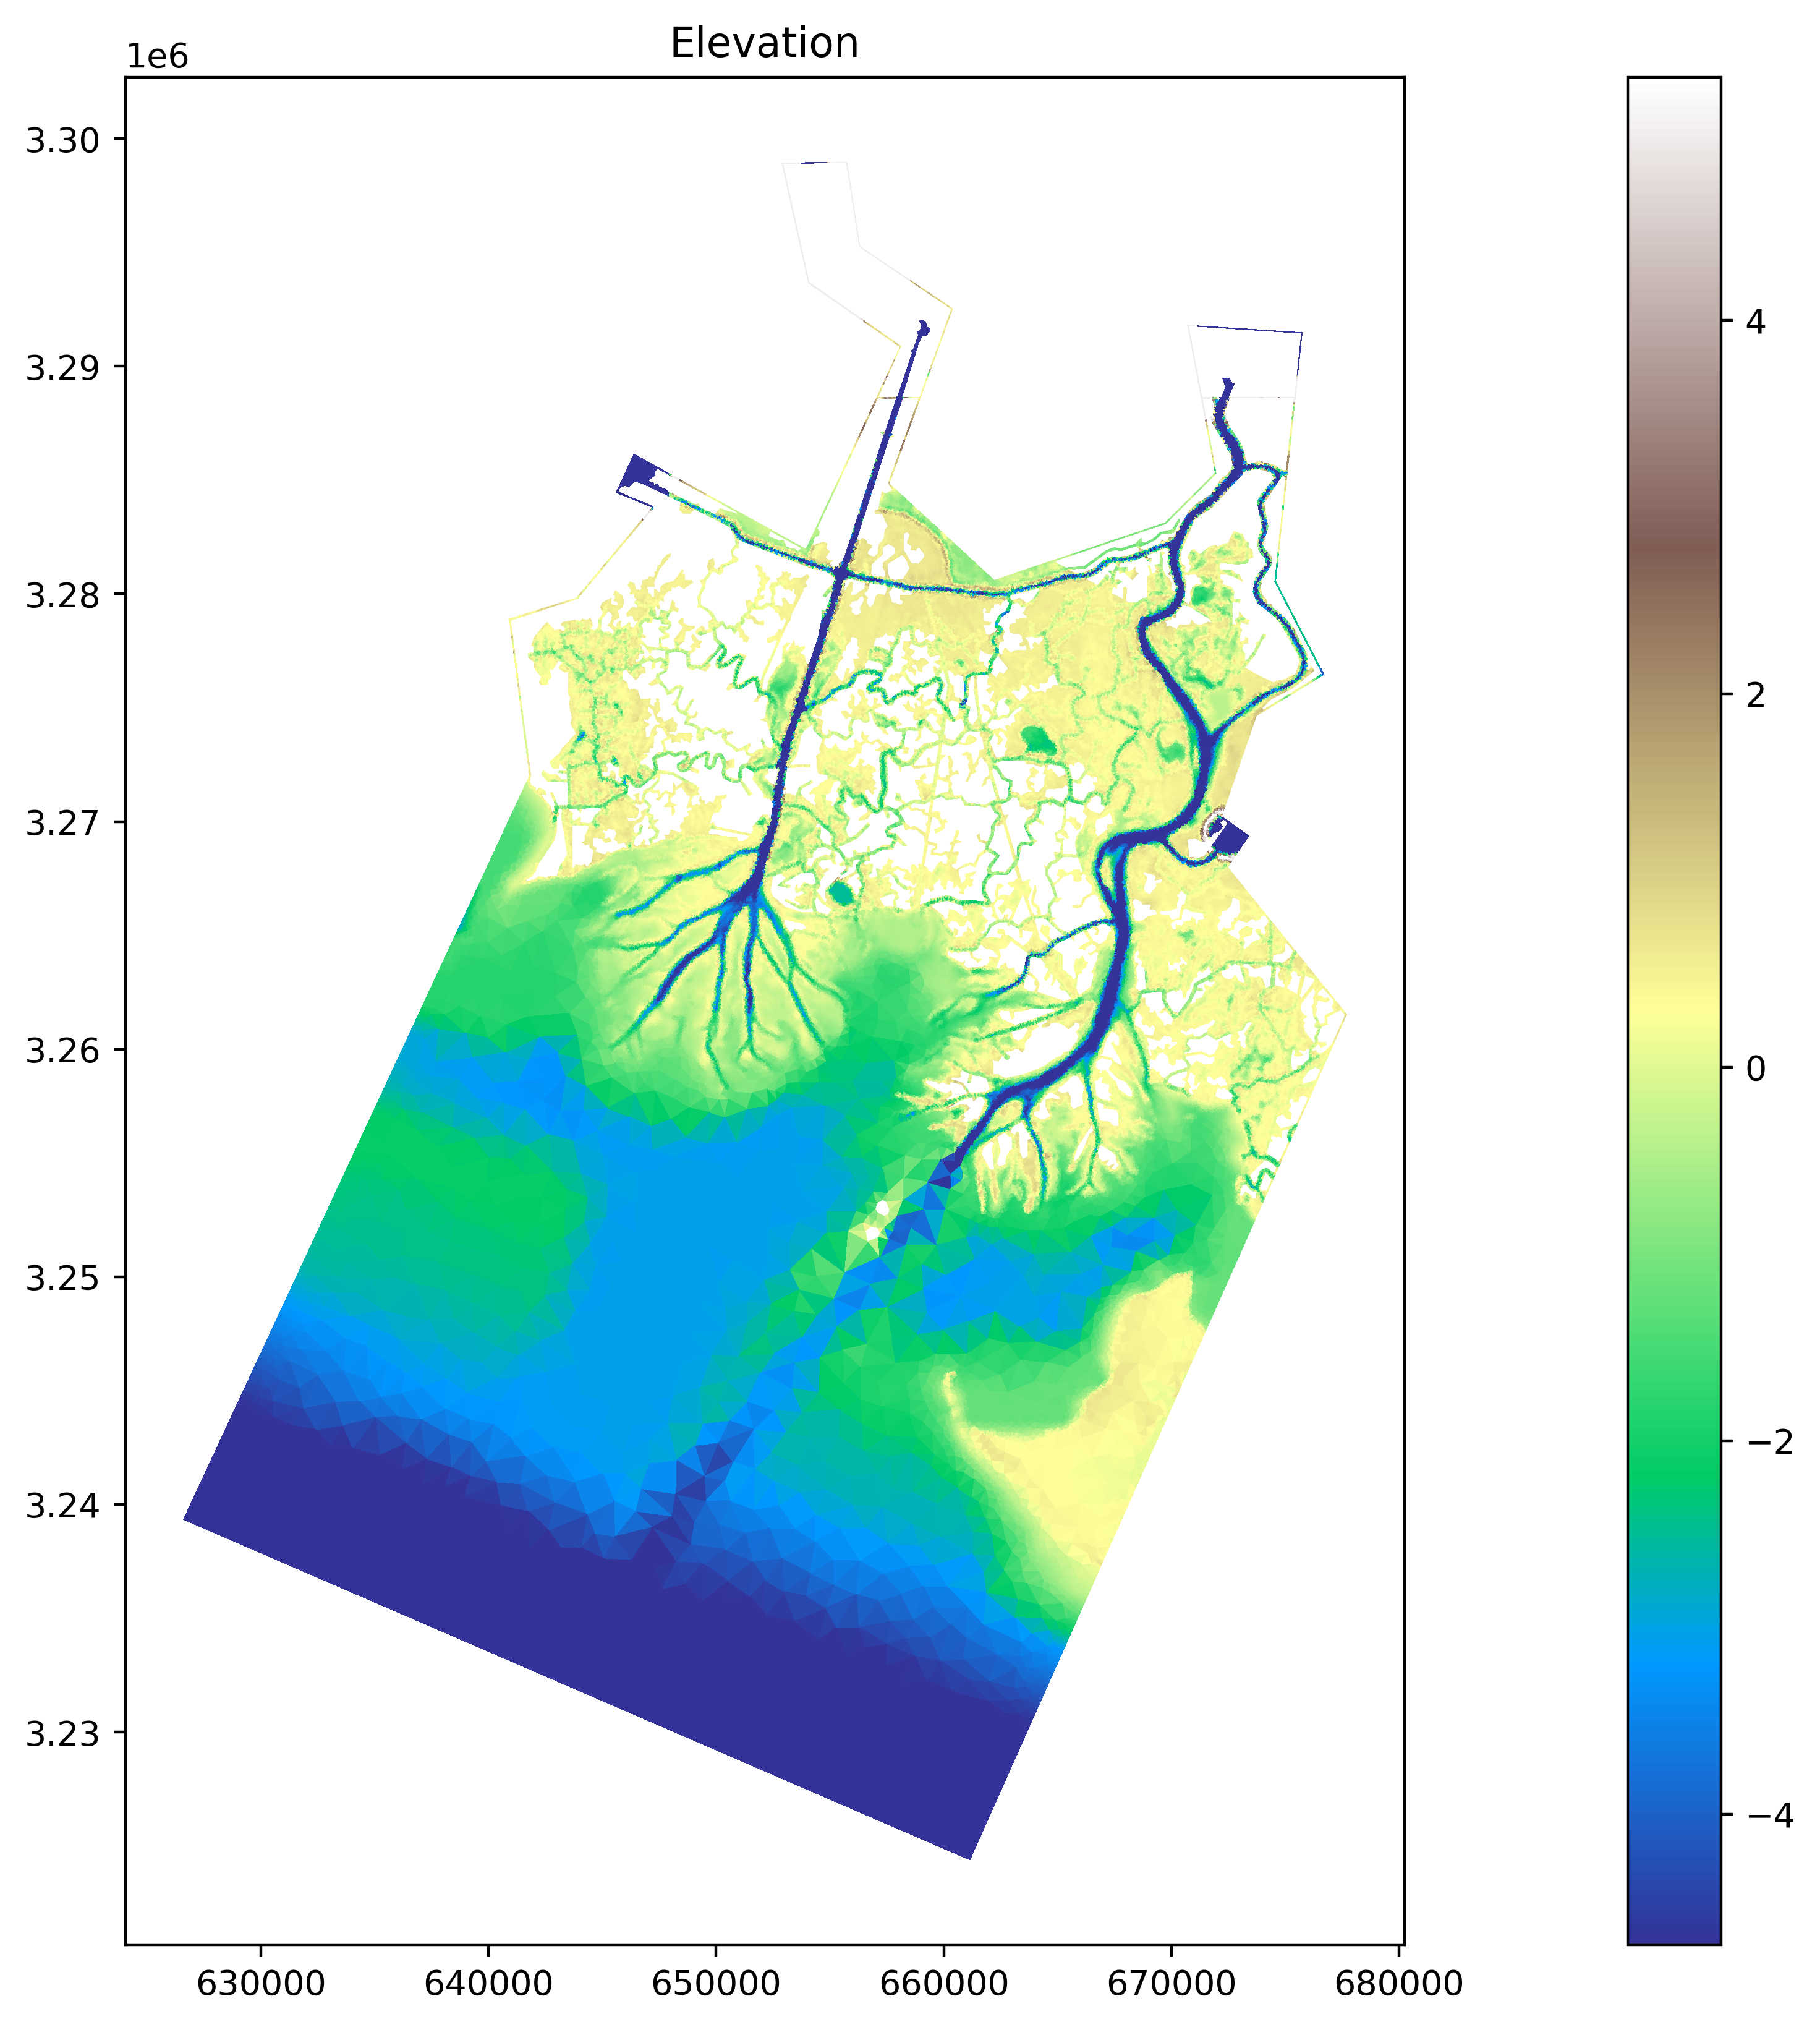

In [ ]:
# Plot bathymetry with a color-axis break at water line
msl = 0.3
fig = plt.figure(figsize=(10, 10), dpi=400, facecolor='w', edgecolor='k')
plt.tripcolor(dplotter.triang, facecolors=dplotter.elev,
              vmax=msl+5, vmin=msl-5, cmap='terrain')
plt.colorbar();
plt.title("Elevation");
plt.axis('scaled')

# Add Tides (Boundary Conditions)

Now we can start adding boundary conditions for our model. We will set it up for a simulation that aligns with the **2021 Delta-X Spring Campaign**. We typically aim for two week simulations, so we will model March 20th through April 3rd.

We have already pre-downloaded the gauge data from the NOAA COOPS website (see `prepare_boundaries` for details) and pre-saved it in a CSV file in the *BoundaryConditions* folder. All we have to do is load that gauge data in, and create an interpolation function that returns water level as a function of time. This is done behind the scenes using `GenerateTideGauge` (which we imported from `tools`).

*Note: All times are specified in seconds after model start time, which in this case is `2021-03-20 00:00:00 UTC`*

In [13]:
# Create interpolation function that returns water level as a function of time
fBC_tides = GenerateTideGauge()

Text(0, 0.5, 'Water Level [$m$]')

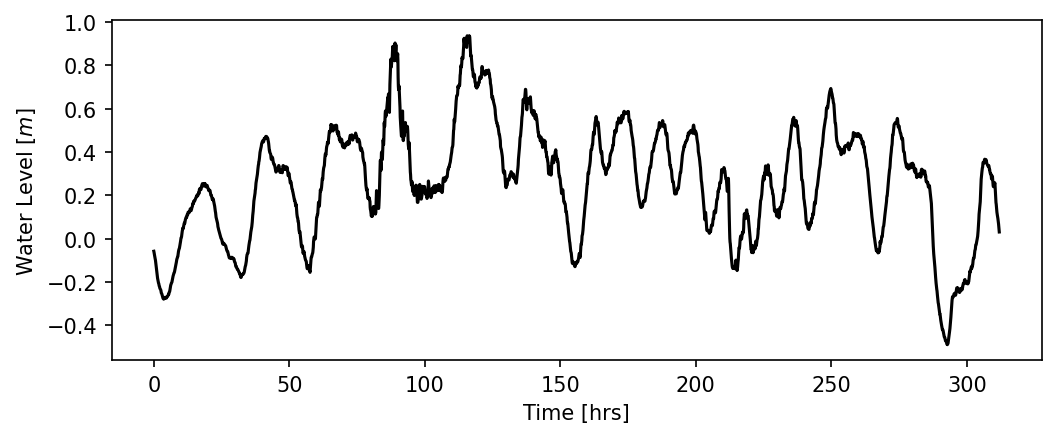

In [16]:
# Visualize tidal boundary condition
tt = np.linspace(0., 13*86400, 3600) # Vector of time values for plotting
BCplt = [fBC_tides(ti) for ti in tt] # Vector of water levels for each tt
plt.figure(figsize=(8,3), dpi=150)
plt.plot(tt/3600., BCplt, 'k-')
plt.xlabel('Time [hrs]')
plt.ylabel('Water Level [$m$]')

In [17]:
# Add tides to our domain using a time-varying Dirichlet
Bout = anuga.Time_boundary(domain,function = lambda t: [fBC_tides(t), 0.0, 0.0])
# Model all other boundaries as no-flux reflective BCs
Br = anuga.Reflective_boundary(domain)

# Specify which one to use at which boundaries
domain.set_boundary({'bay': Bout, 'sides': Br, 'interior': Br})

# Add Discharge

As you may have noticed, we did not specify a discharge inflow when adding boundary conditions in the previous cell. If you're coming from other models, this may seem strange, but it's a quirk of how ANUGA handles boundary conditions. In order to best ensure that the correct amount of mass is entering our domain from upstream, we use something called an `Inlet_operator`, which is literally an **inlet inside our model boundary** through which water enters the domain. You can think of this kind of like a flooding bath drain. This wouldn't be necessary if we were modeling a steep upstream landscape with supercritical flow, but in low-Froude landscapes like river deltas, this method is most accurate. 

Each inlet is a line placed near that inflow, which we surround with reflective boundaries to make sure all of that mass flows into our model domain. Aside from the somewhat unusual implementation, the outcome is the same.

Much like our tidal data, we have pre-downloaded the relevant gauge data from several USGS gauges surrounding our model domain (see `prepare_boundaries` for details) and pre-saved them in CSV files in the *BoundaryConditions* folder. All we need to do is load in the data and create some more interpolation functions that return discharge as a function of time (using another function from `tools`).

In [18]:
# Load in the three time-varying gauges and create hydrograph functions
fQ_WLO = GenerateHydrograph(name_WLO) # Calumet inlet
fQ_ATC = GenerateHydrograph(name_ATC) # Morgan City inlet
fQ_FRA = GenerateHydrograph(name_FRA) # Franklin outlet
# Avoca outlet discharge constant and set by Q_AVO in settings

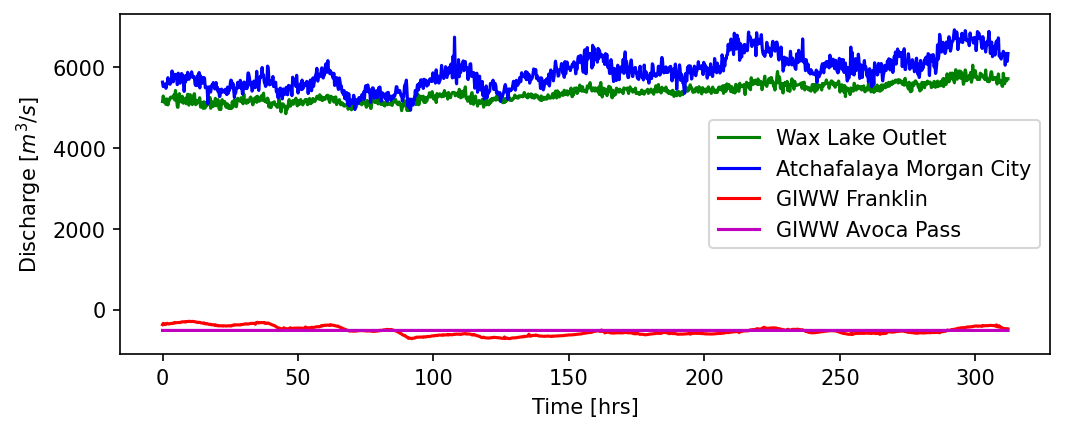

In [19]:
# Visualize time-varying Q
tt = np.linspace(0., 13*86400, 3600) # Vector of time values for plotting
Qplta = [fQ_WLO(ti) for ti in tt] # Vector of Q values for each tt
Qpltb = [fQ_ATC(ti) for ti in tt] # Vector of Q values for each tt
Qpltc = [fQ_FRA(ti) for ti in tt] # Vector of Q values for each tt
plt.figure(figsize=(8,3), dpi=150)
plt.plot(tt/3600., Qplta, 'g-')
plt.plot(tt/3600., Qpltb, 'b-')
plt.plot(tt/3600., Qpltc, 'r-')
plt.plot(tt/3600., np.ones_like(tt)*Q_AVO, 'm-')
plt.xlabel('Time [hrs]')
plt.ylabel('Discharge [$m^3/s$]')
plt.legend(['Wax Lake Outlet','Atchafalaya Morgan City',
            'GIWW Franklin','GIWW Avoca Pass'])

In [21]:
# Add inlets to our domain
inlet_WLO = Inlet_operator(domain, Q_WLO_loc, Q = fQ_WLO)
inlet_ATC = Inlet_operator(domain, Q_ATC_loc, Q = fQ_ATC)
outlet_FRA = Inlet_operator(domain, Q_FRA_loc, Q = fQ_FRA)
outlet_AVO = Inlet_operator(domain, Q_AVO_loc, Q = Q_AVO)

# Initialize Stage

Now we just need to add a few more initial conditions to our model, beginning with the starting water surface elevation (i.e. `stage`). If we had ouptuts from a previous model run, we could use those to initialize our new model with the `set_quantity()` function, which can be used for `stage`, `xmomentum`, and `ymomentum`. 

Here we will perform a "cold start", meaning static initial conditons. All we will specify is a starting water surface elevation equal to our initial tidal water level.

In [ ]:
stage = topo.copy()  # Initialize stage as = topography
stage[topo <= fBC_tides(0)] = fBC_tides(0) # Use BC(0) for IC

# Add to domain
domain.set_quantity('stage', stage, location='centroids')  # Initialize depth

# Initialize Friction

Lastly, we will add friction to our model. We do this using a classification map containing six friction classes:
1. Open ocean / Atchfalaya bay
2. Large channels
3. Small wetland channels
4. Subtidal vegetation
5. Intertidal vegetation
6. Supratidal vegetation

Classes 1-3 are open water classes that are modeled according to Manning's equation, and are given appropriate Manning's coefficients. Classes 4-6 are vegetated classes which we model using the equation from [Baptist et al., (2007)](https://www.tandfonline.com/doi/abs/10.1080/00221686.2007.9521778), for which we have specified representative vegetation densities, stem diameters, and stem heights. The `Baptist_operator` is a custom add-on that we have created for ANUGA and implement here. 

The friction classification map is a living document and is getting updated as we process more remote sensing data, and the coefficients are listed as a set of arrays in the `settings` file, so it is easily adjustable for improved calibration during different seasons or conditions. 

In [24]:
x = domain.quantities['x'].centroid_values
y = domain.quantities['y'].centroid_values
FricVal = Raster2Mesh(x, y) # Interpolate from raster onto grid
n, m, hv, D = AssignFricValue(FricVal) # Assign to each cell

# Assign Mannings
domain.set_quantity('friction', n, location = 'centroids')
# Assign Baptist
bapt_op = Baptist_operator(domain,
                           veg_diameter=D,
                           veg_density=m,
                           veg_height=hv,
                           use_diffusivity=False)

# Wind Forcing

For the current demonstration we have left off wind, which can be computationally expensive. However, the model implentation does include wind, which can be turned on or off depending on the environmental conditions. Feel free to look at `run_parallel.py` to see how wind is implemented in the actual model (hint: search for the variable `wind_on`).

# Note on Parallelization

We have kept the current demonstration serialized in order to make sure it runs correctly on Colab and potentially people's local machines. However, if we had designed this code to run in parallel, the workflow would be similar and is generally structured as follows:
1. Load packages and data
2. Build the model on processor 0
3. Distribute smaller pieces of the model over the available processors
4. Run the model
5. Recombine the outputs

Feel free to glance through `run_parallel.py` to see what this looks like in practice.

# Run the Model

Finally, we can run the model!

Here we call on `domain.evolve()` to **run the model** for a specified amount of time. There are two kinds of timesteps to be aware of: the **model timestep** and the **yieldstep**. In ANUGA, the model timestep is automatically computed based on numerical stability conditions, and is usually some small value $\approx \mathcal{O}(1s)$. However, we can't save the data for every timestep, because output file would be enormous. We therefore specify a yieldstep, which is the time interval (in seconds) at which the model **saves information** on the model's converved quantities (`stage`, `xmomentum`, `ymomentum`) into the output file. We use the command `domain.print_timestepping_statistics()` to tell us some summary statistics of these timesteps every `yieldstep`.

As the model runs, output data are saved into a NetCDF file with the extension `.sww`. This is a common and efficient data type for storing numeric data, and can be opened by many programs.

The `domain.evolve()` function works like a typical *for* loop: *for t less than final time, evolve the model*. This enables us to **make changes to our model** as time progresses, if we wish. In this example, all of our BCs were defined as functions of time, so they are automatically updated each time step, but they also could have been defined as static values and then updated inside this loop.

In [ ]:
# Evolve the domain
for n, t in enumerate(domain.evolve(yieldstep=timestep, finaltime=finaltime)):
    # As the model progresses, print statistics on the time-stepping
    domain.print_timestepping_statistics()

As the model evolves, you should see timestepping statistics printed out every yieldstep. Here's the meaning for those numbers:
- The first value is the "real" amount of time that has been modeled so far.
- "delta t" is the range of model timesteps taken during that yieldstep.
- "steps" is the number of model timesteps taken in that yieldstep.
- The number in the parentheses at the end is the amount of clock time that has elapsed since the last yieldstep, i.e. how long you'll have to wait for the model to finish.

# Analyze Model Outputs

Now we can view some results!

There is a pre-saved output file in the GitHub folder, which you can use if you don't want to wait for your run to finish.

There are a couple ways one can query the output file. ANUGA's `.sww` files can be loaded using any normal NetCDF reader, but ANUGA also comes pre-packaged with several functions for inspecting your model results, most of which are stored in `anuga.utilities.plot_utils`.

First, load in the data:

In [ ]:
# Uncomment whichever one we're visualizing:
saved_output = 'WLAD.sww' # Output of current run
# saved_output = 'ANUGA_OnionCreek_Tutorial/notebooks/domain.sww' # Pre-saved output

# Load in values of conserved quantities at every cell centroid
swwvals = anuga.utilities.plot_utils.get_centroids(saved_output, timeSlices='all')
# Query values: time, x, y, stage, elev, height, xmom, ymom, xvel, yvel, friction, vel, etc
model_starttime = pd.to_datetime('2022-03-21 17:00:00')
dplotter = animate.SWW_plotter(saved_output) # Update dplotter if necessary

# Separate variables just for accessibility
time = swwvals.time
topo = swwvals.elev
x = swwvals.x
y = swwvals.y
depth = swwvals.height
stage = swwvals.stage
u = swwvals.xvel
v = swwvals.yvel
w = np.sqrt(u**2 + v**2)

# Return to Powerpoint Presentation